Here we use a simple linear model and article content with `CountVectorizer`.

Import libraries.

In [38]:
import os
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, SelectFromModel
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from scipy import sparse

from html.parser import HTMLParser
from tqdm import tqdm_notebook
from functools import reduce
from statistics import mean
from datetime import datetime

The following code will help to throw away all HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
PATH_TO_DATA = 'data_6'

Assume you have all data downloaded from competition's [page](https://www.kaggle.com/c/how-good-is-your-medium-article/data) in the PATH_TO_DATA folder and `.gz` files are ungzipped.

In [3]:
!ls -l $PATH_TO_DATA

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Supplementary function to read a JSON line without crashing on escape characters. 

In [4]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

This function takes a JSON and forms a txt file leaving only article content. When you resort to feature engineering and extract various features from articles, a good idea is to modify this function.

In [5]:
def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            data = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            data_no_html_tags = strip_tags(data)
            output_list.append(data_no_html_tags)
    return output_list

In [77]:
%%time
# train_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'), content)
train_title = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'))

Wall time: 21.3 s


In [78]:
%%time
# test_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'), content)
test_title = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'))

Wall time: 13.4 s


We'll use a linear model (`Ridge`) with a very simple feature extractor – `CountVectorizer`, meaning that we resort to the Bag-of-Words approach. For now, we are leaving only 50k features. 

In [83]:
cv = TfidfVectorizer(ngram_range=(1, 3), max_features=150_000)  # cv = CountVectorizer(max_features=50000)

In [84]:
%%time
X_train_title = cv.fit_transform(tqdm_notebook(train_title))

Wall time: 5.05 s


In [85]:
%%time
X_test_title = cv.transform(tqdm_notebook(test_title))

Wall time: 1.08 s


In [86]:
print(X_train_title.shape, X_test_title.shape)

sparse.save_npz('data_6/train_titile(1-2).npz', X_train_title)
sparse.save_npz('data_6/test_titile(1-2).npz', X_test_title)

(62313, 150000) (34645, 150000)


In [48]:
# Подгружаем готовые матрицы контента
X_train = sparse.load_npz('data_6/train_content(1-2).npz')
X_test = sparse.load_npz('data_6/test_content(1-2).npz')
train_title = sparse.load_npz('data_6/train_titile(1-2).npz')
test_title = sparse.load_npz('data_6/test_titile(1-2).npz')

print(train_title.shape, test_title.shape)

(62313, 150000) (34645, 150000)


In [44]:
# Фичи через н-граммы

# cv = TfidfVectorizer(ngram_range=(1, 2), max_features=150_000) 
# # Добавим и разрядим авторов
# with open('data_6/train_title_pickle', 'rb') as pick:
#     train_title = pickle.load(pick)
#     train_title_vector = cv.fit_transform(tqdm_notebook(train_title))
    
# with open('data_6/test_title_pickle', 'rb') as pick:
#     test_title = pickle.load(pick)
#     test_title_vector = cv.fit_transform(tqdm_notebook(test_title))

In [45]:
print(train_title_vector.shape, test_title_vector.shape)

(62313, 150000) (34645, 150000)


In [49]:
# Фичи через даммиес
def add_features(df):
    dumm = pd.get_dummies(df)

    return dumm

# Авторы
with open('data_6/total_author_pickle', 'rb') as pick:
    tags = pickle.load(pick)
    train_author_dumm = add_features(tags)[:62313]
    test_author_dumm = add_features(tags)[62313:]

# Время
with open('data_6/train_time_pickle', 'rb') as pick:
    time = pickle.load(pick)
    time = [datetime.strptime(st, '%H:%M:%S').hour for st in time]
    train_time_dumm = add_features(time)
    
with open('data_6/test_time_pickle', 'rb') as pick:
    time = pickle.load(pick)
    time = [datetime.strptime(st, '%H:%M:%S').hour for st in time]
    test_time_dumm = add_features(time)

# Дни недели и месяцы
with open('data_6/train_date_pickle', 'rb') as pick:
    date = pickle.load(pick)
    weekday = [datetime.strptime(st, '%Y-%m-%d').weekday() for st in date]
    month = [datetime.strptime(st, '%Y-%m-%d').month for st in date]
    train_day_dumm = add_features(weekday)
    train_month_dumm = add_features(month).iloc[:, np.r_[0:3, 6:12]]
    
with open('data_6/test_date_pickle', 'rb') as pick:
    date = pickle.load(pick)
    weekday = [datetime.strptime(st, '%Y-%m-%d').weekday() for st in date]
    month = [datetime.strptime(st, '%Y-%m-%d').month for st in date]
    test_day_dumm = add_features(weekday)
    test_month_dumm = add_features(month)

In [9]:
print(train_month_dumm.shape, test_month_dumm.shape)

(62313, 9) (34645, 9)


In [50]:
# Скалирование
def scalling(data):
    return MinMaxScaler().fit_transform(data.reshape(-1, 1))
    
with open('data_6/train_reading_t_pickle', 'rb') as pick:
    train_reading = np.log(np.array(list(map(float, pickle.load(pick)))))
    train_reading_scal = scalling(train_reading)
    
with open('data_6/test_reading_t_pickle', 'rb') as pick:
    test_reading = np.log(np.array(list(map(float, pickle.load(pick)))))
    test_reading_scal = scalling(test_reading)

In [11]:
print(train_reading_scal.shape, test_reading_scal.shape)

(62313, 1) (34645, 1)


In [51]:
# Соединяем фичи
X_train_sparse = hstack([X_train,
                         train_title,
                         train_author_dumm,
                         train_reading_scal,
                         train_time_dumm,
                         train_day_dumm,
                         train_month_dumm
                        ]).tocsr()

X_test_sparse = hstack([X_test, 
                        test_title,
                        test_author_dumm,
                        test_reading_scal,
                        test_time_dumm,
                        test_day_dumm,
                        test_month_dumm
                       ]).tocsr()

In [52]:
print(X_train_sparse.shape, X_test_sparse.shape)

(62313, 344286) (34645, 344286)


In [142]:
# Поработаем со всеми фичами
# X_train_sparse = VarianceThreshold(0.0001).fit_transform(X_train_sparse)
# X_test_sparse = VarianceThreshold(0.0001).fit_transform(X_test_sparse)
# X_train_sparse.shape, X_test_sparse.shape

((62313, 2365), (34645, 3717))

Read targets from file.

In [11]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [12]:
train_target.shape

(62313, 1)

In [13]:
y_train = train_target['log_recommends'].values

Make a 30%-holdout set. 

In [149]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

Now we are ready to fit a linear model.

In [34]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.75, random_state=17)

In [156]:
# %%time
# ridge_alphas = np.linspace(0.5, 1, 5)
# print(ridge_alphas)
# ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='neg_mean_absolute_error', cv=2)
# tqdm_notebook(ridge_cv.fit(X_train_sparse, y_train))

# print(ridge_cv.coef_, "\n",
#       ridge_cv.alpha_, "\n"
#      );
ridge.fit(X_train_sparse, y_train)

In [157]:
ridge_pred = ridge.predict(X_test_sparse)

ValueError: dimension mismatch

Let's plot predictions and targets for the holdout set. Recall that these are #recommendations (= #claps) of Medium articles with the `np.log1p` transformation.

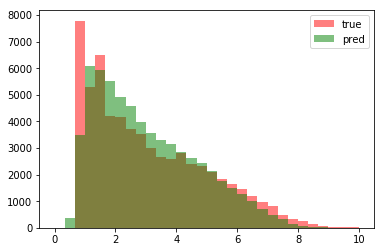

In [18]:
plt.hist(y_train, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_test_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

As we can see, the prediction is far from perfect, and we get MAE $\approx$ 1.3 that corresponds to $\approx$ 2.7 error in #recommendations.

In [ ]:
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

Finally, train the model on the full accessible training set, make predictions for the test set and form a submission file. 

In [55]:
%%time
ridge.fit(X_train_sparse, y_train);

Wall time: 2min 14s


Ridge(alpha=0.75, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [56]:
print(len(ridge.coef_))

344286


In [57]:
%%time
ridge_test_pred = ridge.predict(X_test_sparse)

Wall time: 192 ms


In [30]:
# lgb_x_train = lgb.Dataset(X_train_sparse.astype(np.float32), label=y_train)

# num_round = 50
# param = {'num_leaves': 31, 'num_trees': 100, 'objective': 'mean_absolute_error', 'metric': 'mae'}

# bst_lgb = lgb.train(param, lgb_x_train, num_round)
# lgb_test_pred = bst_lgb.predict(X_test_sparse.astype(np.float32))

c:\users\tom\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [132]:
# mix_pred = 0.6 * lgb_test_pred + 0.4 * ridge_test_pred

In [36]:
def write_submission_file(prediction, filename, path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission['log_recommends'] = [x+1 for x in submission['log_recommends']]
    submission.to_csv(filename)

In [62]:
write_submission_file(prediction=ridge_test_pred, filename='first_ridge_1.csv')

In [37]:
# Объединим все признаки, чтобы прогнать их через фиче-инженерию


# Делаем единый контент и тайтл
content_list = []
title_list = []
def preprocess(path_to_inp_json_file):
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            data = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            data_no_html_tags = strip_tags(data)
            content_list.append(data_no_html_tags)
            
            data = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            data_no_html_tags = strip_tags(data)
            title_list.append(data_no_html_tags)
    return content_list, title_list


train_content, train_title = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'))
full_content, full_title = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'))

In [39]:
# Векторизируем контент и тайтл
cv = TfidfVectorizer(ngram_range=(1, 2), max_features=150_000)
X_full_content = cv.fit_transform(tqdm_notebook(full_content))

cv = TfidfVectorizer(ngram_range=(1, 3), max_features=150_000)
X_full_title = cv.fit_transform(tqdm_notebook(full_title))

In [6]:
# Сохраним/загрузим матрицы

# sparse.save_npz('data_6/total_content.npz', X_full_content)
# sparse.save_npz('data_6/total_title.npz', X_full_title)

total_content = sparse.load_npz('data_6/total_content.npz')
total_title = sparse.load_npz('data_6/total_title.npz')

In [7]:
# Фичи через даммиес
def add_features(df):
    dumm = pd.get_dummies(df)

    return dumm

# Авторы
with open('data_6/total_author_pickle', 'rb') as pick:
    author = pickle.load(pick)
    total_author_dumm = add_features(author)

# Время
with open('data_6/total_time_pickle', 'rb') as pick:
    time = pickle.load(pick)
    time = [datetime.strptime(st, '%H:%M:%S').hour for st in time]
    total_time_dumm = add_features(time)

# Дни недели и месяцы
with open('data_6/total_date_pickle', 'rb') as pick:
    date = pickle.load(pick)
    weekday = [datetime.strptime(st, '%Y-%m-%d').weekday() for st in date]
    week = [datetime.strptime(st, '%Y-%m-%d').isocalendar()[1] for st in date]
    total_day_dumm = add_features(weekday)
    total_week_dumm = add_features(week)

In [8]:
# Скалирование
def scalling(data):
    return MinMaxScaler().fit_transform(data.reshape(-1, 1))
    
with open('data_6/total_reading_t_pickle', 'rb') as pick:
    total_reading = np.log(np.array(list(map(float, pickle.load(pick)))))
    total_reading_scal = scalling(total_reading)

In [22]:
Total_sparse = hstack([total_content,
                         total_title,
                         total_author_dumm,
                         total_reading_scal,
                         total_time_dumm,
                         total_day_dumm,
                         total_week_dumm
                        ]).tocsr()

In [ ]:
# Селектим фичи
# Total_sparse_ = VarianceThreshold(0.00001).fit_transform(Total_sparse)
k_selector = SelectKBest(mutual_info_regression, k=100_000)
k_selector.fit_transform(Total_sparse[:62313], y_train)
print(k_selector.get_support())

In [ ]:
Total_train_sparse = Total_sparse[:62313, k_selector.get_support()]
Total_test_sparse = Total_sparse[62313:, k_selector.get_support()]

In [ ]:
ridge.fit(Total_train_sparse, y_train)
ridge_test_pred = ridge.predict(Total_test_sparse)
write_submission_file(prediction=ridge_test_pred, filename='first_ridge_10.csv')



With this, you'll get 1.91185 on [public leaderboard](https://www.kaggle.com/c/how-good-is-your-medium-article/leaderboard). This is much higher than our validation MAE. This indicates that the target distribution in test set somewhat differs from that of the training set (recent Medium articles are more popular). This shouldn't confuse us as long as we see a correlation between local improvements and improvements on the leaderboard. 

Some ideas for improvement:
- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used `C`=1 as a regularization parameter, this can be changed 
- SGD and Vowpal Wabbit will learn much faster
- In our course, we don't cover neural nets. But it's not obliged to use GRUs or LSTMs in this competition. 